# Setting up with BigQuery
[This notebook](https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=ONI1Xo0-KtAD) provides a great tutorial on how to set up BigQuery access with Google Colab

In [ ]:
import pandas as pd

In [ ]:
#mount drive
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#enter project id
project_id = 'patent-classification-313315'

In [ ]:
#import bigquery
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Two options:
The user can either upload a csv file to their drive that contains the publication numbers of active patents they want to analyze. The file should be formatted with "publication_number" as the column name, and the patents should be formatted with "US-patent_number-patent_kind_code", ex: "US-123456-A1".
Alternatively, the user can query patents based on a keyword phrase they provide. It will then return all patent matches that contain that phrase. 

## Option 1

In [ ]:
#load in dataframe of pub numbers of desired patents to work with 
#we are working with patents in pharmacology and patient insurance
#mount to drive and find file path for appropriate project
df = pd.read_csv("/content/drive/MyDrive/Practicum/sample_pub_numbers.csv")
df.head()

In [ ]:
dest_dataset = 'desired_publication_numbers'
# Upload these to our dataset on BigQuery.
ID_table = 'ID_table'
full_table_path = '{}.{}'.format(dest_dataset, ID_table)
df.to_gbq(full_table_path, project_id, if_exists = "replace")

In [ ]:
df = client.query('''
#standardSQL

WITH P AS (
  SELECT 
  publication_number, 
  floor(priority_date / 10000) priority_yr
  FROM `patents-public-data.patents.publications`
  WHERE country_code = 'US'
  AND floor(priority_date / 10000) >= 1950
  AND country_code = 'US'
)

SELECT 
P.publication_number,
P.priority_yr,
abstracts.text
FROM `patents-public-data.patents.publications` as pubs,
UNNEST(abstract_localized) as abstracts
JOIN P 
  ON P.publication_number = pubs.publication_number
JOIN `patent-classification-313315.desired_publication_numbers.ID_table` my_pubs
  ON pubs.publication_number = my_pubs.publication_number
WHERE abstracts.language = 'en'
''').to_dataframe()

## Option 2

In [ ]:
df = client.query('''
  SELECT * FROM
  `patents-public-data.patents.publications` AS patentsdb,
  UNNEST(abstract_localized) AS abstract_info
  # enter query phrase to search patents for
  WHERE LOWER(abstract_info.text) LIKE '%virus%'
    AND patentsdb.country_code = 'US'
  ORDER BY patentsdb.priority_date DESC
  # enter max number of patents to analyze in results
  LIMIT 200
''').to_dataframe()

In [ ]:
df.head()

,publication_number,application_number,country_code,kind_code,application_kind,application_number_formatted,pct_number,family_id,title_localized,abstract_localized,claims_localized,claims_localized_html,description_localized,description_localized_html,publication_date,filing_date,grant_date,priority_date,priority_claim,inventor,inventor_harmonized,assignee,assignee_harmonized,examiner,uspc,ipc,cpc,fi,fterm,locarno,citation,parent,child,entity_status,art_unit,text,language,truncated
0,US-2021052922-A1,US-202017093213-A,US,A1,A,US17093213,,74646516,[{'text': 'Ppe with rotating assembly providin...,[{'text': 'A personal protective device (PPE) ...,[{'text': '1 . A PPE device configured to for ...,"[{'text': '<claims mxw-id=""PCLM282664602"" lang...",[{'text': 'BACKGROUND OF THE INVENTION F...,"[{'text': '<description mxw-id=""PDES286586638""...",20210225,20201109,0,20201109,"[{'publication_number': '', 'application_numbe...","[CHEN, ANDY, WANG, CINDY JINGRU, BRYAN, ALLEN,...","[{'name': 'CHEN ANDY', 'country_code': 'US'}, ...",[Golden Galaxy Corporation],"[{'name': 'GOLDEN GALAXY CORP', 'country_code'...",[],[],"[{'code': 'A62B18/04', 'inventive': True, 'fir...","[{'code': 'A41D13/1153', 'inventive': True, 'f...",[],[],[],[],[],[],,,A personal protective device (PPE) comprising ...,en,False
1,US-2021052922-A1,US-202017093213-A,US,A1,A,US17093213,,74646516,[{'text': 'Ppe with rotating assembly providin...,[{'text': 'A personal protective device (PPE) ...,[{'text': '1 . A PPE device configured to for ...,"[{'text': '<claims mxw-id=""PCLM282664602"" lang...",[{'text': 'BACKGROUND OF THE INVENTION F...,"[{'text': '<description mxw-id=""PDES286586638""...",20210225,20201109,0,20201109,"[{'publication_number': '', 'application_numbe...","[CHEN, ANDY, WANG, CINDY JINGRU, BRYAN, ALLEN,...","[{'name': 'CHEN ANDY', 'country_code': 'US'}, ...",[Golden Galaxy Corporation],"[{'name': 'GOLDEN GALAXY CORP', 'country_code'...",[],[],"[{'code': 'A62B18/04', 'inventive': True, 'fir...","[{'code': 'A41D13/1153', 'inventive': True, 'f...",[],[],[],[],[],[],,,A personal protective device (PPE) comprising ...,en,False
2,US-2021103656-A1,US-202017090924-A,US,A1,A,US17090924,,75274190,[{'text': 'Method and apparatus using virtual ...,[{'text': 'The present invention provides a me...,"[{'text': '1 . A storage system or server, com...","[{'text': '<claims mxw-id=""PCLM285437001"" lang...",[{'text': 'BACKGROUND Field of the inven...,"[{'text': '<description mxw-id=""PDES289309775""...",20210408,20201106,0,20201106,"[{'publication_number': '', 'application_numbe...","[Tahmasebi, Lilly Nahal]","[{'name': 'TAHMASEBI LILLY NAHAL', 'country_co...",[Lilly Nahal Tahmasebi],"[{'name': 'TAHMASEBI LILLY NAHAL', 'country_co...",[],[],"[{'code': 'G06F21/55', 'inventive': True, 'fir...","[{'code': 'G06N5/04', 'inventive': True, 'firs...",[],[],[],[],[],[],,,The present invention provides a method and ap...,en,False
3,US-2021103656-A1,US-202017090924-A,US,A1,A,US17090924,,75274190,[{'text': 'Method and apparatus using virtual ...,[{'text': 'The present invention provides a me...,"[{'text': '1 . A storage system or server, com...","[{'text': '<claims mxw-id=""PCLM285437001"" lang...",[{'text': 'BACKGROUND Field of the inven...,"[{'text': '<description mxw-id=""PDES289309775""...",20210408,20201106,0,20201106,"[{'publication_number': '', 'application_numbe...","[Tahmasebi, Lilly Nahal]","[{'name': 'TAHMASEBI LILLY NAHAL', 'country_co...",[Lilly Nahal Tahmasebi],"[{'name': 'TAHMASEBI LILLY NAHAL', 'country_co...",[],[],"[{'code': 'G06F21/55', 'inventive': True, 'fir...","[{'code': 'G06N5/04', 'inventive': True, 'firs...",[],[],[],[],[],[],,,The present invention provides a method and ap...,en,False
4,US-10948287-B1,US-202017083670-A,US,B1,A,US17083670,,74870492,[{'text': 'Wearable device for spacing awarene...,[{'text': 'A wearable device for spacing aware...,[{'text': 'What is claimed is: 1...,"[{'text': '<claims mxw-id=""PCLM283830702"" lang...",[{'text': 'BACKGROUND OF 

In [ ]:
abstracts = df["abstract_localized"]
abstracts_text = []
for i in abstracts:
  for j in i:
    abstract = j["text"]
    if abstract not in abstracts_text:
      abstracts_text.append(abstract)
    else:
      pass

In [ ]:
#we lose some values as some abstracts are repeated in the initial query
len(abstracts_text)

111

In [ ]:
abstracts_text[0:5]

['A personal protective device (PPE) comprising a face cover assembly and a bodysuit configured to be worn by a human user. The device protects users against airborne aerosol particles containing viruses or other infectious agents while enabling improved flexibility relative to prior art designs. The device includes a helmet-like” rotating face cover assembly that fits over the user&#39;s head and attaches to a collar on the biohazard bodysuit. This rotating face cover assembly has a plurality of different mask sides, each with differing geometries or other properties. The device enables a user to can rotate the cover and select a given mask side that best meets that user&#39;s needs. The different mask sides can accommodate different facial geometries, eyewear types, and use cases.',
 'The present invention provides a method and apparatus for a highly secure Air-Gapped storage or repository (Transportable Storage). The apparatus has a storage stack that can be completely isolated and 

## Optional
Here you can add your own idea for a patent abstract and see where it falls within the landscape

In [ ]:
#enter text below
your_patent = "Enter your patent here"
abstracts_text.append(your_patent)

# Import BERT Model and Encode Messages
Hugging face has [several pretrained BERT models](https://huggingface.co/models). You can use one trained on patents for general use. In our case, one on biomedical data might be more applicable. It is easy to import the different models, so find one that seems to work best for you

In [ ]:
import tensorflow as tf

In [ ]:
! pip install -Uq sentence-transformers

     |████████████████████████████████| 92kB 6.5MB/s 
     |████████████████████████████████| 2.5MB 25.9MB/s 
     |████████████████████████████████| 1.2MB 43.0MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 
     |████████████████████████████████| 901kB 39.7MB/s 
ERROR: transformers 4.8.2 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.


In [ ]:
import pandas as pd
import scipy
import numpy as np
import sklearn
from sentence_transformers import models, SentenceTransformer, util
from sklearn.cluster import KMeans
from sentence_transformers import util
from sklearn.metrics.pairwise import cosine_similarity
# choose a model relevant to this project
# "AI-Growth/PatentSBERTa is a great general patent BERT model"
# for this task, we're using a model trained on biomedical abstracts, which is relevant to our research
model = SentenceTransformer('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#Create Clusters

In [ ]:
#change number below to adjust amount of clusters
clusters = 5
sentence_embeddings = model.encode(abstracts_text)
kmeans = KMeans(n_clusters=clusters).fit(sentence_embeddings)
kmeans.labels_

array([3, 4, 4, 4, 4, 4, 1, 3, 3, 1, 4, 3, 4, 3, 3, 4, 4, 2, 2, 3, 3, 3,
       1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 4, 3, 3, 4, 4, 4, 3, 3, 1, 1, 1,
       3, 3, 1, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1,
       3, 2, 2, 1, 1, 1, 4, 1, 1, 1, 3, 3, 1, 1, 1, 1, 4, 1, 3, 3, 1, 3,
       1], dtype=int32)

In [ ]:
combined_dataset = []
# use this if using an original patent
for i in range(len(abstracts_text)):
  if i == len(abstracts_text)-1:
    label = kmeans.labels_[i]
    abstract = abstracts_text[i]
    source = "patent original"
    instance = (abstract, source, label)
    combined_dataset.append(instance)
  else:
    label = kmeans.labels_[i]
    abstract = abstracts_text[i]
    source = "patent"
    instance = (abstract, source, label)
    combined_dataset.append(instance)

In [ ]:
combined_dataset = []
# use this if not using an original patent
for i in range(len(abstracts_text)):
  label = kmeans.labels_[i]
  abstract = abstracts_text[i]
  source = "patent"
  instance = (abstract, source, label)
  combined_dataset.append(instance)

# Import New Research and Apply to Existing Clusters
Google has many [public datasets](https://cloud.google.com/bigquery/public-data). Feel free to find one relevant to the patents you are landscaping! In this demo, we are using biomedical research on covid-19

In [ ]:
#can replace arxiv with other research database
research_df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.breathe.arxiv`
''').to_dataframe()

In [ ]:
research_abstracts = research_df["abstract"]
research_abstracts_clean = []
#remove \n that is in the text
for i in research_abstracts:
  clean = i.replace('\n',' ')
  research_abstracts_clean.append(clean)

In [ ]:
#research_sample = research_abstracts_clean[1:10]
research_embeddings = model.encode(research_abstracts_clean)
research_labels = kmeans.predict(research_embeddings)

In [ ]:
for i in range(len(research_abstracts_clean)):
  label = research_labels[i]
  abstract = research_abstracts_clean[i]
  source = "research"
  instance = (abstract, source, label)
  combined_dataset.append(instance)

# Create combined dataset

In [ ]:
combined_df = pd.DataFrame(combined_dataset, columns =['Abstract', 'Source', 'Label'])
combined_df.head()

,Abstract,Source,Label
0,A personal protective device (PPE) comprising ...,patent,3
1,The present invention provides a method and ap...,patent,4
2,A wearable device for spacing awareness includ...,patent,4
3,A bandage with a center that elevates over an ...,patent,4
4,COVID-19 is a large virus with remarkable resi...,patent,4


In [ ]:
combined_df["Source"].value_counts()

patent      111
research     71
Name: Source, dtype: int64

#Visualize Results

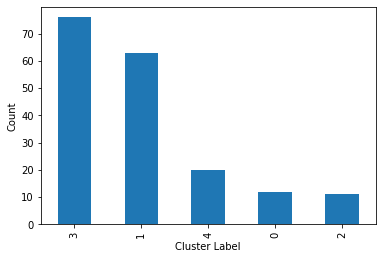

In [ ]:
import matplotlib
from matplotlib import pylab as plt
pd.value_counts(combined_df['Label']).plot.bar()
plt.ylabel('Count')
plt.xlabel('Cluster Label')
plt.show()

# Download Created Dataframe

In [ ]:
from google.colab import files

combined_df.to_csv('patent_and_research_abstracts.csv')
files.download('patent_and_research_abstracts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>